# Problema da Designação

O **Problema da Designação** é um caso especial do **Problema de Transporte** em que o objetivo é atribuir um conjunto de tarefas a um conjunto de agentes (ou recursos), minimizando o custo total ou maximizando a eficiência da alocação. Esse problema aparece em diversas áreas, como planejamento de produção, alocação de trabalhadores e otimização de processos. 

In [2]:
import cplex
import networkx as nx
import matplotlib.pyplot as plt
import string

## Leitura e e pré-processamento dos dados

Dado um conjunto de **$n$** agentes e um conjunto de **$n$** tarefas, queremos atribuir cada agente a exatamente uma tarefa, de forma a minimizar o custo total. O problema pode ser representado por uma **matriz de custos** $C = [c_{ij}]$, onde:  
- $c_{ij}$ representa o **custo** para o agente $i$ executar a tarefa $j$.  
- $x_{ij}$ é uma variável de decisão, onde:  

  $x_{ij} =
  \begin{cases} 
  1, \quad \text{se o agente } i \text{ for designado à tarefa } j \\ 
  0, \quad \text{caso contrário}
  \end{cases}$

In [3]:
file = "in_desig.txt"

with open(file, 'r') as f:
    lines = f.readlines()
    lines = [line.strip() for line in lines]
    lines = list(filter(None, lines))

num_nodes, num_edges = map(int, lines[0].strip().split())

pessoas = []
tarefas = []
letras = string.ascii_uppercase  # 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

for linha in lines[1:num_nodes+1]:
    node_id, tipo = map(int, linha.split())
    if tipo == 0:
        pessoas.append(node_id)
    elif tipo == 1:
        tarefas.append(node_id)

costs = [[0 for _ in range(len(tarefas))] for _ in range(len(pessoas))]
for line in lines[num_nodes+1:]:
    partes = line.split()
    if len(partes) >= 3:
        source, target, cost = int(partes[0]), int(partes[1]), int(partes[2])
        # Verifica se a origem é uma pessoa e o destino é uma tarefa
        if source in pessoas and target in tarefas:
            # Obtém o índice da pessoa e da tarefa na ordem definida
            i = pessoas.index(source)
            j = tarefas.index(target)
            costs[i][j] = cost

print("Pessoas:", pessoas)
print("Tarefas:", tarefas)
print("Matriz de Custos:")
for line in costs:
    print(" ".join(map(str, line)))

Pessoas: [0, 1, 2]
Tarefas: [3, 4, 5]
Matriz de Custos:
40 37 35
36 38 34
29 25 26


## Visualização do Problema

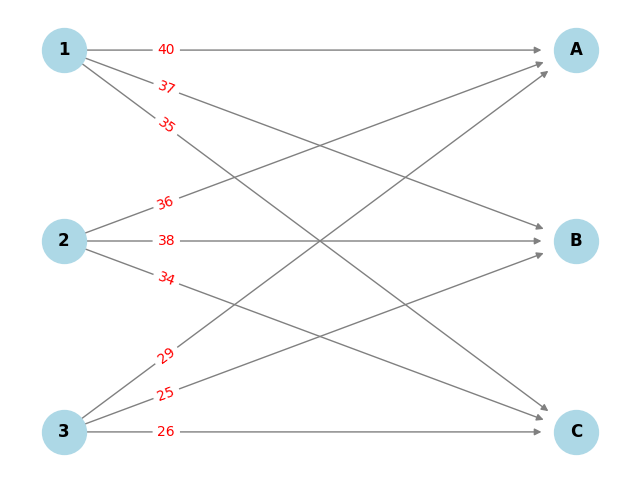

In [4]:
G = nx.DiGraph()

labels = {}
for idx, p in enumerate(pessoas):
    node_label = pessoas[idx] + 1
    G.add_node(p, bipartite=0, label=node_label)
    labels[p] = node_label

for idx, t in enumerate(tarefas):
    node_label = letras[idx]
    G.add_node(t, bipartite=1, label=node_label)
    labels[t] = node_label

for i, p in enumerate(pessoas):
    for j, t in enumerate(tarefas):
        if costs[i][j] != 0:
            G.add_edge(p, t, weight=costs[i][j])

pos = {}
for idx, p in enumerate(pessoas):
    pos[p] = (0, -idx)
for idx, t in enumerate(tarefas):
    pos[t] = (1, -idx)

edge_labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_weight='bold')
nx.draw_networkx_edges(
    G, pos,
    arrowstyle='-|>',
    arrowsize=10,
    min_target_margin = 25,
    edge_color='gray'
    )
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', label_pos=0.8)

plt.axis('off')
plt.show()

## Modelagem e Solução

O objetivo é minimizar o custo total da designação:  
$\min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{ij} \cdot x_{ij}$

Sujeito às restrições:  

1. **Cada agente executa apenas uma tarefa**:  
$\sum_{j=1}^{n} x_{ij} = 1, \quad \forall i \in \{1, \dots, n\}$

2. **Cada tarefa é atribuída a apenas um agente**:  
$\sum_{i=1}^{n} x_{ij} = 1, \quad \forall j \in \{1, \dots, n\}$

3. **Variáveis binárias** (um agente só pode ser designado ou não):  
$x_{ij} \in \{0,1\}, \quad \forall i, j$

In [5]:
model = cplex.Cplex()
model.objective.set_sense(model.objective.sense.minimize)

n = len(pessoas)

variaveis = [f"x{i+1}{letras[j]}" for i in range(n) for j in range(n)]
num_variaveis = len(variaveis)
lb = [0.0] * num_variaveis
ub = [1.0] * num_variaveis
types = [model.variables.type.binary] * num_variaveis

# Função objetivo
objetivo = [costs[i][j] for i in range(n) for j in range(n)]

# Definir as variáveis: binárias (0 ou 1)
model.variables.add(names=variaveis, obj=objetivo, lb=lb, ub=ub, types=types)

# Cada pessoa é designado a exatamente uma tarefa
for i in range(n):
    indices = [f"x{i+1}{letras[j]}" for j in range(n)]
    coef = [1.0] * n
    model.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=indices, val=coef)],
        senses=["E"],
        rhs=[1.0],
        names=[f"pessoa_{i}"]
    )

# Cada tarefa é designada a exatamente uma pessoa
for j in range(n):
    indices = [f"x{i+1}{letras[j]}" for i in range(n)]
    coef = [1.0] * n
    model.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=indices, val=coef)],
        senses=["E"],
        rhs=[1.0],
        names=[f"tarefa_{letras[j]}"]
    )

%time model.solve()

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec


CPXPARAM_Read_DataCheck                          1
Found incumbent of value 104.000000 after 0.00 sec. (0.00 ticks)
Found incumbent of value 99.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIP has 6 rows, 9 columns, and 18 nonzeros.
Reduced MIP has 9 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.01 ticks)
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIP has 6 rows, 9 columns, and 18 nonzeros.
Reduced MIP has 9 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.01 ticks)
Probing time = 0.00 sec. (0.00 ticks)
Clique table members: 6.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.01 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0        

## Sumário dos resultados

In [6]:
print("Status da solução:", model.solution.get_status_string())
print(f"Custo total: {model.solution.get_objective_value()}")
assignment = {}
sol_values = model.solution.get_values()
for i in range(n):
    for j in range(n):
        idx = i * n + j
        if sol_values[idx] > 0.5:  # Considera 1 se > 0.5
            assignment[i] = j
            print(f"Pessoa {i+1} designada a tarefa {letras[j]}")

model.write("./output/model_desig.lp")
model.solution.write("./output/solution_desig.sol")

assignment

Status da solução: integer optimal solution
Custo total: 96.0
Pessoa 1 designada a tarefa C
Pessoa 2 designada a tarefa A
Pessoa 3 designada a tarefa B


{0: 2, 1: 0, 2: 1}

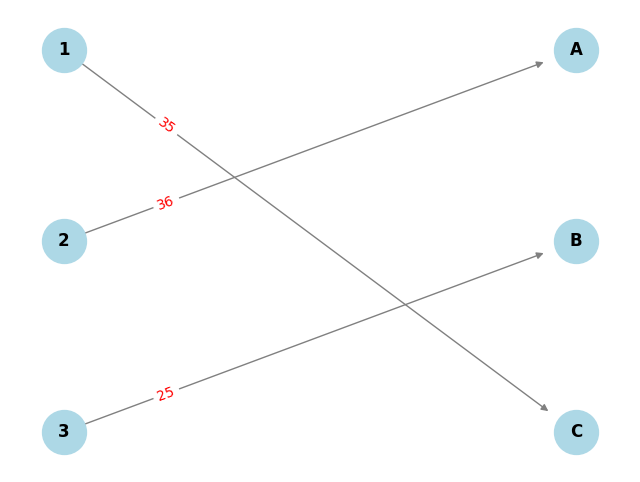

In [7]:
G = nx.DiGraph()

labels = {}
for idx, p in enumerate(pessoas):
    node_label = pessoas[idx] + 1
    G.add_node(p, bipartite=0, label=node_label)
    labels[p] = node_label

for idx, t in enumerate(tarefas):
    node_label = letras[idx]
    G.add_node(t, bipartite=1, label=node_label)
    labels[t] = node_label

for i, p in enumerate(assignment):
    G.add_edge(pessoas[i], tarefas[assignment[p]], weight=costs[i][assignment[p]])

pos = {}
for idx, p in enumerate(pessoas):
    pos[p] = (0, -idx)
for idx, t in enumerate(tarefas):
    pos[t] = (1, -idx)

edge_labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_weight='bold')
nx.draw_networkx_edges(
    G, pos,
    arrowstyle='-|>',
    arrowsize=10,
    min_target_margin = 25,
    edge_color='gray'
    )
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', label_pos=0.8)

plt.axis('off')
plt.show()